In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [35]:
# this function is used to visualise the confusion matrix for the model
def visualize_preds(table,y_true, y_pred, title):
    ls = []
    f = plt.figure(figsize = (8,8))
    cf = confusion_matrix(y_true, y_pred)
    sb.heatmap(cf, fmt='.0f', annot=True)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))

    # Metrics for Binary Confusion Matrices
    if sum(cf[:,1]) == 0:
        precision = 0.0;
    else:
        precision = cf[1,1] / sum(cf[:,1])
        
    if sum(cf[1,:]) == 0:
        recall = 0.0;
    else:
        recall    = cf[1,1] / sum(cf[1,:])
        
    if (precision + recall) == 0:
        f1_score = 0.0;
    else:
        f1_score  = 2 *precision * recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy,precision,recall,f1_score)
    
    ls.append(accuracy)
    ls.append(precision)
    ls.append(recall)
    ls.append(f1_score)
    ls = pd.DataFrame(ls)
    table = pd.concat([table,ls], axis = 1)
    
    plt.xlabel('Predicted' + stats_text)
    plt.ylabel('Actual')
    plt.title(title)
    
    return table

In [4]:
table1 = pd.DataFrame()
table2 = pd.DataFrame()

In [5]:
cleanTrainData = pd.read_csv('clean-train-data.csv')
cleanTrainData.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Risk_Class
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,No Risk
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,No Risk
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,No Risk
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Risk
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Risk


In [11]:
# Converting categorical values to numeric values using one hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
# OneHotEncoding of categorical predictors (not the response)
cleanTrainData_cat = cleanTrainData[['Married/Single','House_Ownership','Car_Ownership']]
ohe.fit(cleanTrainData_cat)
cleanTrainData_cat_ohe = pd.DataFrame(ohe.transform(cleanTrainData_cat).toarray(), 
                                  columns=ohe.get_feature_names(cleanTrainData_cat.columns))
                                    #columns=ohe.get_feature_names_out(creditData_cat.columns))
# Check the encoded variables
cleanTrainData_cat_ohe.head()

,Married/Single_married,Married/Single_single,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,Car_Ownership_no,Car_Ownership_yes
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [12]:
cleanTrainData_num=pd.DataFrame(cleanTrainData[["Income","Age","Experience","CURRENT_JOB_YRS","CURRENT_HOUSE_YRS","Risk_Flag"]])
combined_data = pd.concat([cleanTrainData_num, cleanTrainData_cat_ohe], 
                           sort = False, axis = 1).reindex(index=cleanTrainData_cat_ohe.index)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Income                        252000 non-null  int64  
 1   Age                           252000 non-null  int64  
 2   Experience                    252000 non-null  int64  
 3   CURRENT_JOB_YRS               252000 non-null  int64  
 4   CURRENT_HOUSE_YRS             252000 non-null  int64  
 5   Risk_Flag                     252000 non-null  int64  
 6   Married/Single_married        252000 non-null  float64
 7   Married/Single_single         252000 non-null  float64
 8   House_Ownership_norent_noown  252000 non-null  float64
 9   House_Ownership_owned         252000 non-null  float64
 10  House_Ownership_rented        252000 non-null  float64
 11  Car_Ownership_no              252000 non-null  float64
 12  Car_Ownership_yes             252000 non-nul

In [28]:
# Upsampling the No Risk in Risk_Flag to the same number as Risk in Risk_Flag
from sklearn.utils import resample

# combined_data has OHE done, contains both numeric and categorical data
risk = combined_data[combined_data.Risk_Flag == 1]
no_risk = combined_data[combined_data.Risk_Flag == 0]
 
# Upsample the Bad samples
risk_up = resample(risk, 
                        replace=True,                     # sample with replacement
                        n_samples=no_risk.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
combined_data_up = pd.concat([no_risk,risk_up])
 
# Check the ratio of the classes
combined_data_up['Risk_Flag'].value_counts()

0    221004
1    221004
Name: Risk_Flag, dtype: int64

In [29]:
combined_data_up.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Married/Single_married,Married/Single_single,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,Car_Ownership_no,Car_Ownership_yes
0,1303834,23,3,3,13,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,7574516,40,10,9,13,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,3991815,66,4,4,10,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
5,6915937,64,0,0,12,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
6,3954973,58,14,8,12,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [30]:
# Getting the X_train, X_vali, y_train and y_vali data
y = pd.DataFrame(combined_data_up['Risk_Flag'])
X = pd.DataFrame(combined_data_up.drop('Risk_Flag',axis = 1))

# Split the Dataset into Train and Test
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.25)

In [31]:
no_risk_count,risk_count =y_train['Risk_Flag'].value_counts()
print(risk_count)
print(no_risk_count)
total = no_risk_count + risk_count

165745
165761


In [32]:
y_train.value_counts()

Risk_Flag
0            165761
1            165745
dtype: int64

In [33]:
odds = risk_count/no_risk_count+risk_count
print(odds)
#Calculate the odd of a risk flag
print("The odds of having a risk in train dataset is\t: {}".format(odds))

#Perform the logistics regression
logreg1 = LogisticRegression()
 
#Fit the data
logreg1.fit(X_train,y_train)

#Print out the mean acuuracy
print("The overall classification accuracy \t\t: ", logreg1.score(X_vali,y_vali))

165745.9999034755
The odds of having a risk in train dataset is	: 165745.9999034755
The overall classification accuracy 		:  0.49992760312030554


/Users/eecheerlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


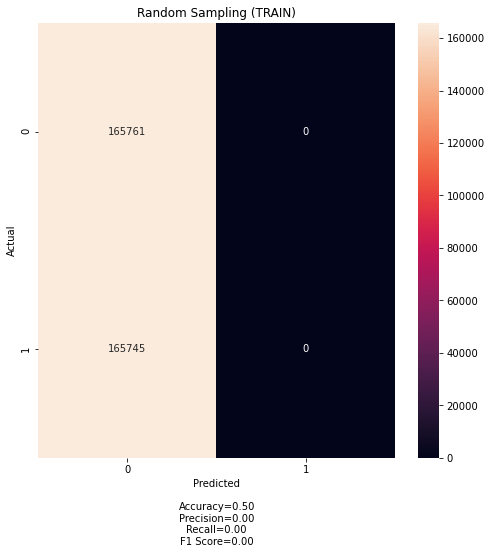

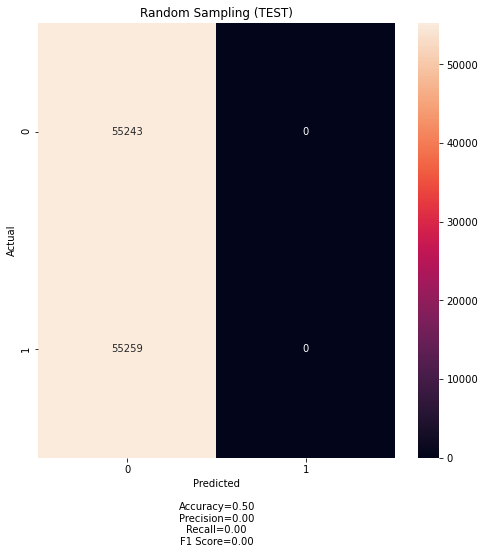

In [34]:
#Predict the data
y_train_pred = logreg1.predict(X_train)
y_vali_pred = logreg1.predict(X_vali)

#Visualizing the data
table1 = visualize_preds(table1,y_train,y_train_pred, title = 'Random Sampling (TRAIN)')
table2 = visualize_preds(table2,y_vali,y_vali_pred, title = 'Random Sampling (TEST)')

Our logistic regression model has an accuracy of 0.5. Unlike linear regression where we use the predictors to predict the numeric response variable, logistic regression uses the predictors to predict a categorical response variable. Even though our logistic regression model may not be the most accurate, we have learnt that such a model to predict categorical variables exist and perhaps we can use it for other projects in the future.